# **Progetto Deblur**

---

Un'azienda vuole commercializzare un dispositivo di acquisizione immagini, del quale si sa che acquisisce con rumore Gaussiano additivo e sfocatura Gaussiana.
Il modello è quindi:

\begin{align*}
    b = A x_{true} + \eta
\end{align*}

Dove $A \in \mathbb{R}^{mn}$ è la matrice di sfocamento, $\eta \sim \mathcal{N}(0, \sigma^2)$ rumore additivo con varianza $\sigma^2$ incognita, $b \in \mathbb{R}^{mn}$ è la vettorizzazione dell'immagine corrotta (acquisita) $B \in \mathbb{R}^{m \times n}$, $x_{true} \in \mathbb{R}^{mn}$ è la vettorizzazione dell'immagine originale $X_{true} \in \mathbb{R}^{m \times n}$.


1. Dopo aver importato le librerie necessarie, assegnare ad una variabile $X$ l'immagine $\texttt{cameraman}$, ottenibile tramite la libreria $\texttt{skimage.data}$ con il nome di $\texttt{camera()}$, effettuarne il $\texttt{reshape}$ e assegnarlo alla variabile $x$.

2. Tramite la funzione $\texttt{skimage.filters.gaussian}$ aggiungere sfocatura Gaussiana ad $X$ per ottenere $X_{blur}$, che rappresenta il reshape ad immagine di $x_{blur} = A x_{true}$, con $A$ matrice di sfocatura.

3. Caricare su una variabile $\eta$, della stessa dimensione di $X_{true}$, una realizzazione di rumore gaussiano con varianza $\sigma = 0.1$ (fare riferimento alle slides per la formula). 
Utilizzare $\eta$ per corrompere l'immagine $X_{blur}$ e calcolare $B = X_{blur} + \eta$. \\
Visualizzare i risultati ottenuti.

In [1]:
def gkern(kernlen, nsig):
  """
  Genera un kernel per la realizzazione di un filtro di sfocatura Gaussiana.

  Input ->
  kernlen: diametro della sfocatura gaussiana.
  nsig:    varianza della sfocatura. Più basso, più sfoca.

  Output -> Kernel Gaussiano di dimensione (kernlen+1) x (kernlen+1) e varianza nsig.
  """
  import scipy.stats as st

  x = np.linspace(-nsig, nsig, kernlen+1)
  kern1d = np.diff(st.norm.cdf(x))
  kern2d = np.outer(kern1d, kern1d)
  return kern2d/kern2d.sum()

def A(x, d=7, sigma=0.5):
  """
  Esegue il prodotto Ax, dove A è la matrice di sfocamento (che, per aumentare l'efficienza, non viene memorizzata).
  
  Input ->
  x:     Immagine di dimensione m x n, che si vuole sfocare.
  d:     Diametro della sfocatura Gaussiana.
  sigma: Varianza della sfocatura Gaussiana.
  
  Output -> Immagine di dimensione m x n, sfocata.
  """
  from scipy.signal import convolve2d
  from numpy import fft
  m, n = x.shape

  K_ext = np.zeros((m, n))
  K = gkern(d, sigma)
  K_ext[:d, :d] = K
  K_ext = fft.fft2(K_ext)
  x = fft.fft2(x)

  return np.real(fft.ifft2(K_ext * x))

def AT(x, d=7, sigma=0.5):
  """
  Esegue il prodotto A^T x, dove A è la matrice di sfocamento (che, per aumentare l'efficienza, non viene memorizzata).
  
  Input ->
  x:     Immagine di dimensione m x n, che si vuole sfocare.
  d:     Diametro della sfocatura Gaussiana.
  sigma: Varianza della sfocatura Gaussiana.
  
  Output -> Immagine di dimensione m x n, sfocata.
  """
  from scipy.signal import convolve2d
  from numpy import fft
  m, n = x.shape

  K_ext = np.zeros((m, n))
  K_ext[:d, :d] = gkern(d, sigma)
  K_ext = fft.fft2(K_ext)
  x = fft.fft2(x)

  return np.real(fft.ifft2(np.conj(K_ext) * x))

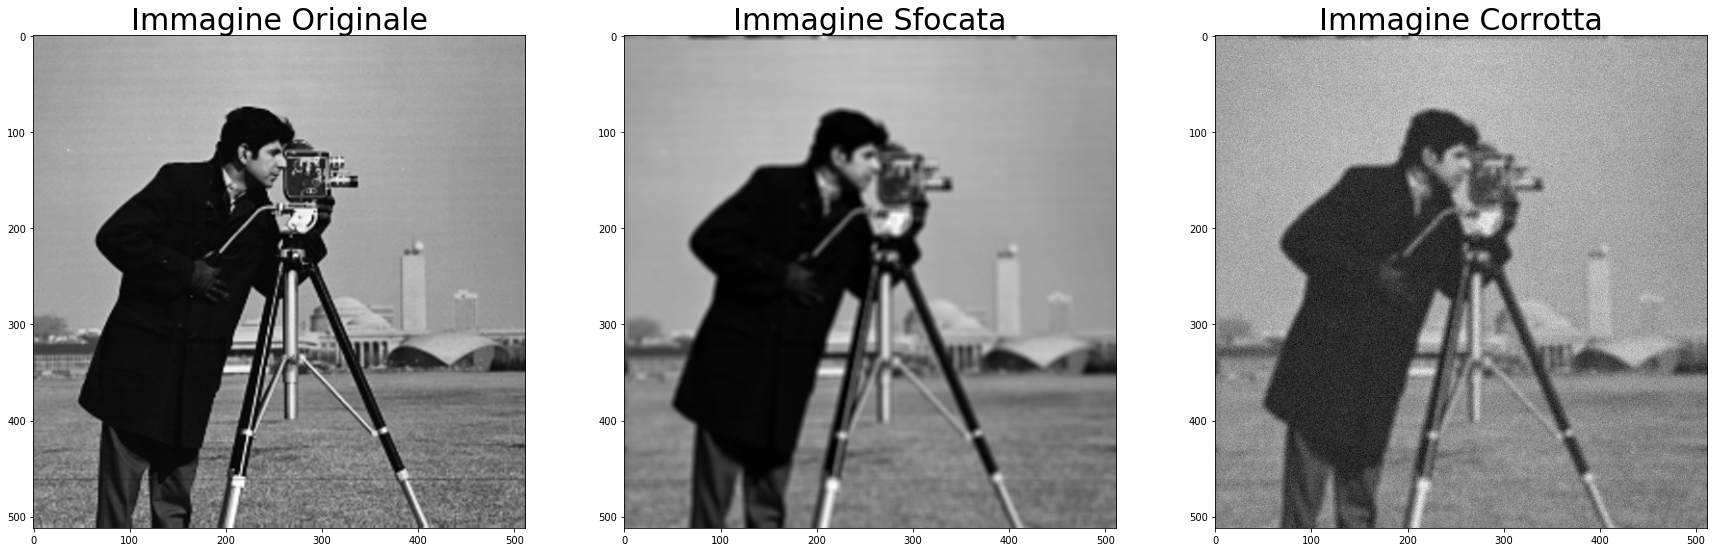

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters

# 1
X = data.camera()
m, n = X.shape
x = X.reshape(m*n)


# 2
# sfocatura dell'immagine
X_blur = A(X)
x_blur = X_blur.reshape(m*n)


# 3
# Generiamo il rumore eta, che aggiungiamo all'immagine sfocata
sigma = 0.1 # Varianza del rumore
eta = np.random.normal(size=X_blur.shape)
eta /= np.linalg.norm(eta, 'fro')
eta *= sigma * np.linalg.norm(X_blur,'fro')

# Aggiungiamo il rumore all'immagine sfocata
B = X_blur + eta
b = B.reshape(m*n)

# Visualizziamo i risultati
plt.figure(figsize=(30, 10))

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=30)

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(X_blur, cmap='gray')
plt.title('Immagine Sfocata', fontsize=30)

ax3 = plt.subplot(1, 3, 3)
ax3.imshow(B, cmap='gray')
plt.title('Immagine Corrotta', fontsize=30)

plt.show()

Il problema di ricostruire l'immagine originale partendo dalla sua corruzione $b$, si può riscrivere come un problema di ottimizzazione

\begin{align}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 \hspace{2cm} (1)
\end{align}

4. Risolvere il problema (1) utilizzando l'algoritmo di discesa del gradiente con scelta del passo tramite backtracking, ricordando che, se 
\begin{align*}
  f(x) = \frac{1}{2} ||Ax - b||_2^2, \hspace{10px} \nabla f(x) = A^T(Ax - b)
\end{align*}
E chiamare la soluzione ottenuta $x_{naive}$.

5. Modificare l'algoritmo precedente a far restituire l'errore tra l'immagine ricostruita al passo $k$ e l'immagine originale, per ogni $k$. Visualizzare il grafico dell'errore, e individuare per quale valore di $k$ si ha semiconvergenza. Per tale valore, calcolare l'immagine ricostruita e chiamarla $x_{trunc}$.

In [3]:
from matplotlib import pyplot as plt

def grafico(iter, er, titolo): 
  err_iter = np.linspace(1, iter, er.size)
  plt.plot(err_iter, er)
  plt.title(titolo)
  plt.grid()
  plt.show()

def grafico_punto(iter, er, x, y, titolo): 
  err_iter = np.linspace(1, iter, er.size)
  plt.plot(err_iter, er)
  plt.plot(x, y, marker="o", color="red")
  plt.title(titolo)
  plt.grid()
  plt.show()

def fun_x(x, b):
  return 0.5 * (np.linalg.norm(A(x) - b)**2)

def gradiente(x, b):
  return AT(A(x) - b)

def backtracking(x, b, grad):  #funzuone di backtracking per calcolare il passo
  alpha = 1.1
  rho = 0.5
  c1 = 0.25
  while (fun_x(x - alpha * grad, b) > (fun_x(x, b) - alpha * c1 * np.linalg.norm(grad, 'fro') ** 2)):
    alpha = alpha * rho
  return alpha

def minimize(x0, x_true, b, maxiterazioni, stop): #funzione per trovare x*
  x = x0
  grad = gradiente(x, b)
  k = 0
  while(np.linalg.norm(grad) > stop) and (k < maxiterazioni):
    x = x - backtracking(x, b, grad) * grad
    grad = gradiente(x, b)
    k = k + 1

  return(x, grad, k)

def minimize_err(x0, x_true, b, maxiterazioni, stop): #funzione per trovare x*
  x = x0
  x_star = x0
  grad = gradiente(x, b)
  errore = np.zeros(maxiterazioni)
  k = 0
  k_star = 0
  while(np.linalg.norm(grad) > stop) and (k < maxiterazioni):
    x = x - backtracking(x, b, grad) * grad
    grad = gradiente(x, b)
    errore[k] = np.linalg.norm(x_true - x) 
    if(errore[k] < errore[k - 1]) and (k > 0):
      k_star = k
      x_star = x 
    k = k + 1
    
  errore = errore[0 : k] 
  return(x_star, grad, k, errore, k_star)

In [4]:
MAXITERAZIONI = 50
STOP = 1.e-5

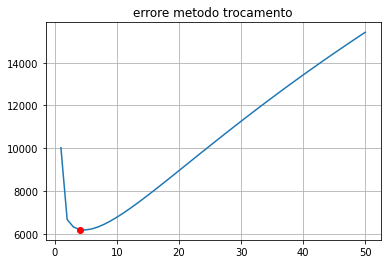

punto errore minore 4 6180.348609506692


Text(0.5, 1.0, 'Immagine Troncata - errore minimo')

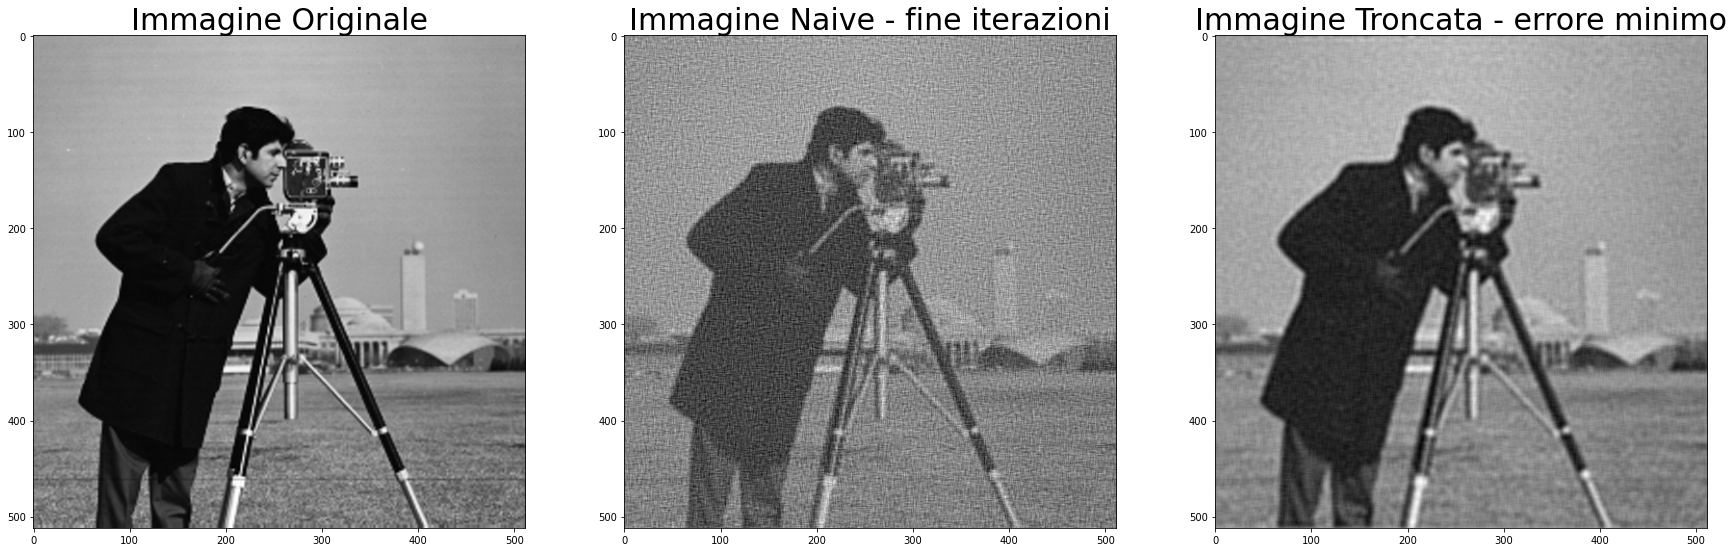

In [5]:
x0 = np.zeros(X.shape)
(x_naive, gradiente_naive, iterazioni_naive) = minimize(x0, X, B, MAXITERAZIONI, STOP)
(x_tronc, gradiente_tronc, iterazioni_tronc, errore_tronc, err_min) = minimize_err(x0, X, B, MAXITERAZIONI, STOP)

grafico_punto(iterazioni_tronc, errore_tronc, err_min, errore_tronc[err_min], 'errore metodo trocamento')
print('punto errore minore', err_min, errore_tronc[err_min])

plt.figure(figsize=(30, 10)) 

im1 = plt.subplot(1, 3, 1)
im1.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=30)

im2 = plt.subplot(1, 3, 2)
im2.imshow(x_naive, cmap='gray')
plt.title('Immagine Naive - fine iterazioni', fontsize=30)

im3 = plt.subplot(1, 3, 3)
im3.imshow(x_tronc, cmap='gray')
plt.title('Immagine Troncata - errore minimo', fontsize=30)

Per risolvere la semiconvergenza, si introduce il problema regolarizzato

\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2 \hspace{2cm} (2)
\end{align*}

con $\lambda > 0$ parametro di regolarizzazione.

6. Sfruttando il fatto che, se
\begin{align*}
f(x) = \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2, \hspace{10px} \nabla f(x) = A^T(Ax - b) + \lambda x
\end{align*}
Risolvere il problema (2) utilizzando l'algoritmo precedente per diversi valori di $\lambda$, e stimare il valore ottimale di $\lambda$ che minimizzi l'errore tra l'immagine ricostruita e l'immagine originale (metodo euristico per il parametro di regolarizzazione). Chiamare $x_{\lambda}$ tale soluzione. \\

7. Stimare il valore ottimale di $\lambda$ tramite principio di discrepanza, ovvero scegliere il più grande $\lambda$ tale che
\begin{align*}
  ||A x_\lambda - b||_2^2 \leq ||\eta||_2^2
\end{align*}
Dove $\eta$ è il rumore. Chiamare $x_\lambda^{disc}$ la soluzione ottenuta dal $\lambda$ calcolato con principio di discrepanza.
 

In [16]:
def fun_reg(x, b, lamb):
  return 0.5 * (np.linalg.norm(A(x)-b))**2 + 0.5 * lamb*np.linalg.norm(x)**2

def gradiente_reg(x, b, lamb):
  return AT(A(x) - b) + lamb * x

def backtracking_reg(x, b, grad, lamb):
  alpha=1.1
  rho = 0.5
  c1 =0.25
  while (fun_reg(x - alpha * grad, b, lamb) > (fun_reg(x, b, lamb) - alpha * c1 * np.linalg.norm(grad, 'fro') ** 2)):
    alpha = alpha * rho
  return alpha


def minimize_reg(b, x0, x_true, lamb, maxiterazioni, stop):
  x = x0
  x_star = x
  grad = gradiente_reg(x, b, lamb)
  errore = np.zeros(maxiterazioni)
  k = 0
  k_star = 0
  while(np.linalg.norm(grad) > stop) and (k < maxiterazioni):
    x = x - backtracking_reg(x, b, grad, lamb) * grad
    grad = gradiente_reg(x, b, lamb)
    errore[k] = np.linalg.norm(x_true - x)
    if(errore[k] < errore[k - 1]) and (k > 0):
      x_star = x
      k_star = k
    k = k + 1
    
  errore = errore[0 : k] 
  return (x_star, grad, k, errore, k_star) 

def lambottimale(b, max):
  lamb= 0.031
  k=0
  (x, gradiente, iterazioni, errore, err_min) = minimize_reg(B, X, B, lamb, max, STOP)
  rat = 1.1
  while (np.linalg.norm(A(x)-b)**2 <= np.linalg.norm(eta)**2):
    print(k)
    lamb *= rat
    (x, gradiente, iterazioni, errore, err_min) = minimize_reg(B, X, B, lamb, max, STOP)
    k+=1
  return lamb/rat

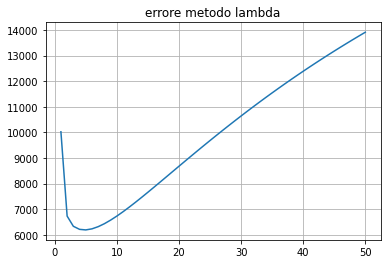

errore lambda: 6189.409599292642


Text(0.5, 1.0, 'Immagine Lambda')

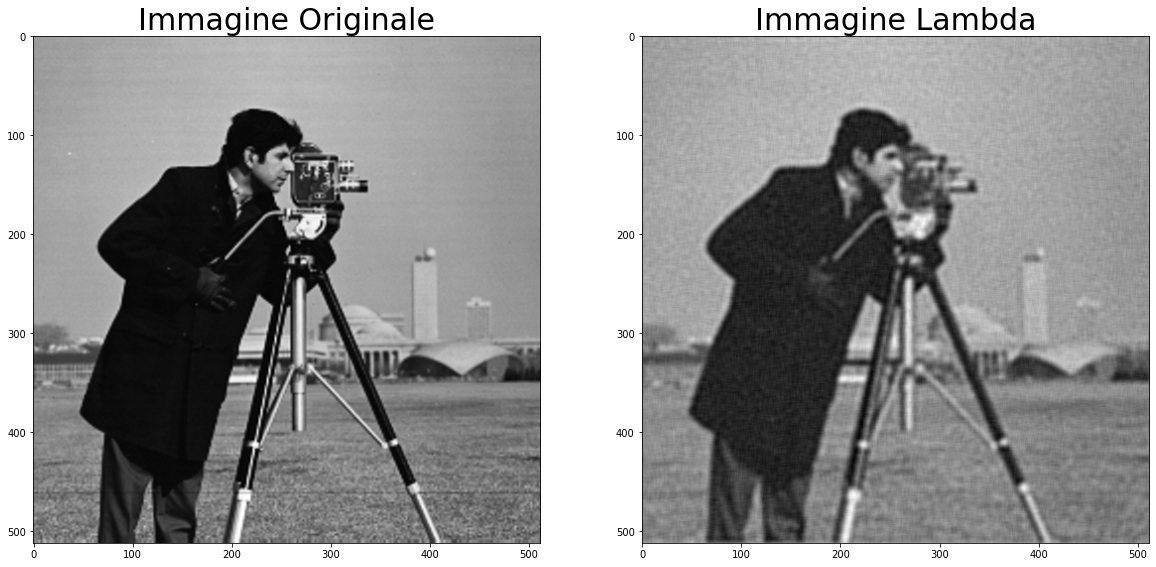

In [15]:
# eursticamente
lamb = 0.005 #a parte
x0 = np.zeros(X.shape)
(x_reg, gradiente_reg, iterazioni_reg, errore_reg, err_min) = minimize_reg(B, x0, X, lamb, MAXITERAZIONI, STOP)

grafico(iterazioni_reg, errore_reg, 'errore metodo lambda')
print('errore lambda:', errore_reg[err_min])

plt.figure(figsize=(20, 10))

im1 = plt.subplot(1, 2, 1)
im1.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=30)

im2 = plt.subplot(1, 2, 2)
im2.imshow(x_reg, cmap='gray')
plt.title('Immagine Lambda', fontsize=30)

0.02818181818181818


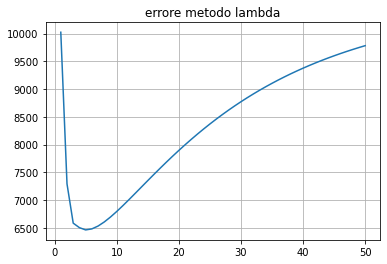

Text(0.5, 1.0, 'Immagine Lambda')

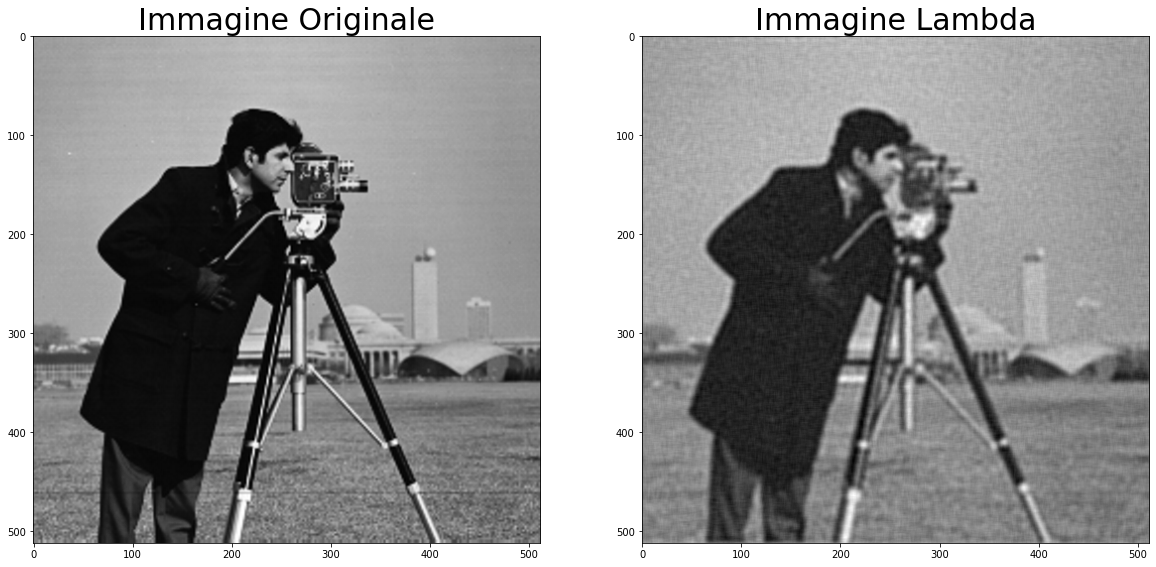

In [17]:
# principio di discrepanza
# x0 = np.zeros(X.shape)
lamb_reg = lambottimale(B, MAXITERAZIONI)
print(lamb_reg)
(x_reg2, gradiente_reg2, iterazioni_reg2, errore_reg2, err_min) = minimize_reg(B, x0, X, lamb_reg, MAXITERAZIONI, STOP)

grafico(iterazioni_reg2, errore_reg2, 'errore metodo lambda')

plt.figure(figsize=(20, 10))

im1 = plt.subplot(1, 2, 1)
im1.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=30)

im2 = plt.subplot(1, 2, 2)
im2.imshow(x_reg2, cmap='gray')
plt.title('Immagine Lambda', fontsize=30)

8. Ripetere quanto fatto nel punto 6, utilizzando la norma 1 come regolarizzatore, ovvero:
\begin{align*}
    x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \lambda ||x||_1 \hspace{2cm} (3)
\end{align*}
Dove la funzione obiettivo ha gradiente
\begin{align*}
  A^T(Ax - b) + \lambda \hspace{2px} sign(x)
\end{align*}

In [18]:
def fun_reg_norm1(x, b, lamb):
  return 0.5 * (np.linalg.norm(A(x) - b)**2) + lamb*np.linalg.norm(x, 1)

def gradiente_reg_norm1(x, b, lamb):
  return AT(A(x) - b) + lamb * np.sign(x)

def backtracking_reg_norm1(x, b, grad, lamb):
  alpha=1.1
  rho = 0.5
  c1 =0.25
  while (fun_reg_norm1(x - alpha * grad, b, lamb) > (fun_reg_norm1(x, b, lamb) - alpha * c1 * np.linalg.norm(grad, 'fro') ** 2)):
    alpha = alpha * rho
  return alpha

def minimize_reg_norm1(b, x0, x_true, lamb, maxiterazioni, stop):
  x = x0
  x_star = x
  grad = gradiente_reg_norm1(x, b, lamb)
  errore = np.zeros(maxiterazioni)
  k = 0
  k_star = 0
  while(np.linalg.norm(grad) > stop) and (k < maxiterazioni):
    x = x - backtracking_reg_norm1(x, b, grad, lamb) * grad
    grad = gradiente_reg_norm1(x, b, lamb)
    errore[k] = np.linalg.norm(x_true - x)
    if(errore[k] < errore[k - 1]) and (k > 0):
      x_star = x
      k_star = k
    k = k + 1
    
  errore = errore[0 : k] 
  return (x_star, grad, k, errore, k_star) 

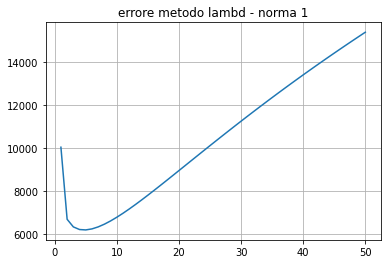

Text(0.5, 1.0, 'Immagine Lambda - Norma 1')

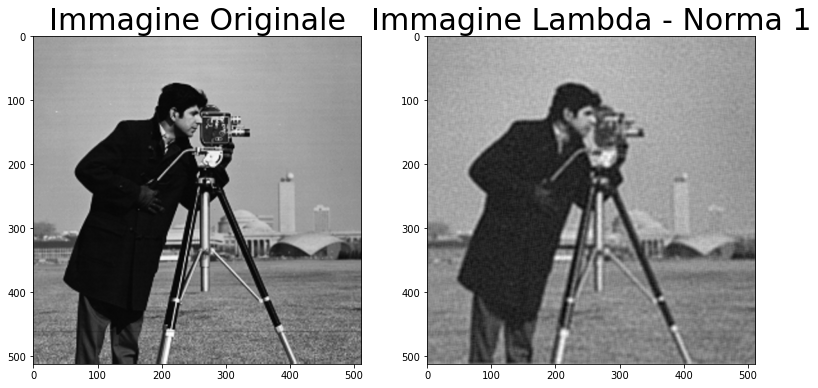

In [19]:
lamb = 4.4 #a parte 
x0 = np.zeros(X.shape)
(x_norm, gradiente_norm, iterazioni_norm, errore_norm, err_min) = minimize_reg_norm1(B, x0, X, lamb_reg, MAXITERAZIONI, STOP)

grafico(iterazioni_norm, errore_norm, 'errore metodo lambd - norma 1')

plt.figure(figsize=(20, 10))

im1 = plt.subplot(1, 3, 1)
im1.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=30)

im2 = plt.subplot(1, 3, 2)
im2.imshow(x_norm, cmap='gray')
plt.title('Immagine Lambda - Norma 1', fontsize=30)

9. ($\textit{facoltativo}$) Ripetere quanto fatto nei punti 6 e 8, utilizzando una norma mista come regolarizzatore, ovvero:
\begin{align*}
    x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2 + \mu ||x||_1 \hspace{2cm} (4)
\end{align*}

In [20]:
def fun_reg_norm_m(x, b, lamb, mu):
  return 0.5*(np.linalg.norm(A(x)-b))**2 + 0.5*lamb*np.linalg.norm(x)**2 + mu*np.linalg.norm(x,1)

def gradiente_reg_norm_m(x, b, lamb, mu):
  return AT(A(x)-b) + lamb*x +  mu*np.sign(x)

def backtracking_reg_norm_m(x, b, grad, lamb, mu):
  alpha=1.1
  rho = 0.5
  c1 =0.25
  while (fun_reg_norm_m(x - alpha * grad, b, lamb, mu) > (fun_reg_norm_m(x, b, lamb, mu) - alpha * c1 * np.linalg.norm(grad, 'fro') ** 2)):
    alpha = alpha * rho
  return alpha

def minimize_reg_norm_m(b, x0, x_true, lamb, mu, maxiterazioni, stop):
  x = x0
  x_star = x
  grad = gradiente_reg_norm_m(x, b, lamb, mu)
  errore = np.zeros(maxiterazioni)
  k = 0
  k_star = 0
  while(np.linalg.norm(grad) > stop) and (k < maxiterazioni):
    x = x - backtracking_reg_norm_m(x, b, grad, lamb, mu) * grad
    grad = gradiente_reg_norm_m(x, b, lamb, mu)
    errore[k] = np.linalg.norm(x_true - x)
    if(errore[k] < errore[k - 1]) and (k > 0):
      x_star = x
      k_star = k
    k = k + 1
    
  errore = errore[0 : k] 
  return (x_star, grad, k, errore, k_star) 

def lambottimale(b, max, mu=0.1):
  lamb= 0.031
  k=0
  (x, gradiente, iterazioni, errore, err_min) = minimize_reg_norm_m(B, X, B, lamb, mu, max, STOP)
  rat = 1.1
  while (np.linalg.norm(A(x)-b)**2 <= np.linalg.norm(eta)**2):
    print(k)
    lamb *= rat
    (x, gradiente, iterazioni, errore, err_min) = minimize_reg_norm_m(B, X, B, lamb, mu, max, STOP)
    k+=1
  return lamb/rat

0.02818181818181818


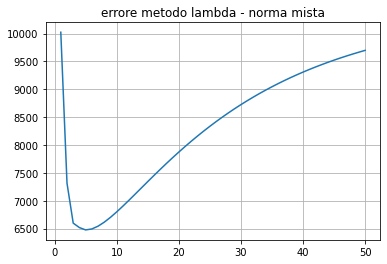

Text(0.5, 1.0, 'Immagine Lambda - Norma mista')

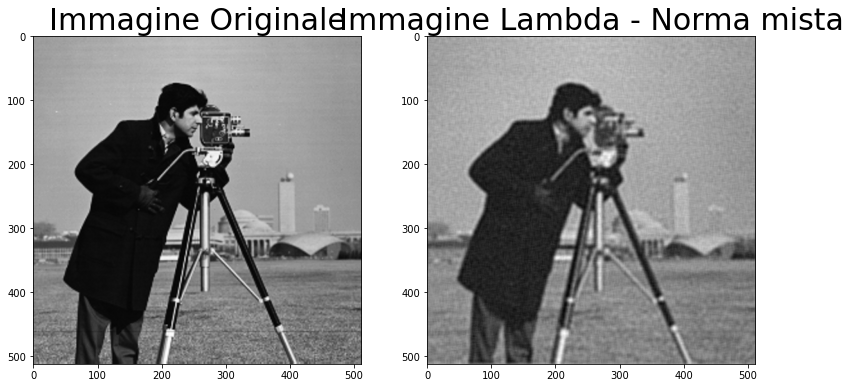

In [21]:
mu = 0.1
lamb_m = lambottimale(B, MAXITERAZIONI, mu) #lamda tramite condizione discrepanza
print(lamb_m)

(x_norm_m, gradiente_norm_m, iterazioni_norm_m, errore_norm_m, err_min_m) = minimize_reg_norm_m(B, x0, X, lamb_m, mu, MAXITERAZIONI, STOP)

grafico(iterazioni_norm_m, errore_norm_m, 'errore metodo lambda - norma mista')

plt.figure(figsize=(20, 10))

im1 = plt.subplot(1, 3, 1)
im1.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=30)

im2 = plt.subplot(1, 3, 2)
im2.imshow(x_norm_m, cmap='gray')
plt.title('Immagine Lambda - Norma mista', fontsize=30)

---

# Analisi dei risultati

---

Per ognuna delle soluzioni trovate, calcolare:

*   Errore relativo rispetto alla soluzione esatta $x_{true}$.
*   PSNR (Peak Signal to Noise Ratio).

Visualizzare le ricostruzioni ottenute con i vari metodi, e confrontare, sia numericamente che attraverso dei grafici, PSNR ed errore relativo ottenuti dalle ricostruzioni. Includere nel confronto, il valore delle metriche per l'immagine corrotta $b$.


In [22]:
def er():
  print("Errore relativo immagine corrotta: ", np.linalg.norm(X - B)/np.linalg.norm(X))
  print("Errore relativo metodo naive: ", np.linalg.norm(X - x_tronc)/np.linalg.norm(X))
  print("Errore relativo metodo euristico: ", np.linalg.norm(X - x_reg)/np.linalg.norm(X))
  print("Errore relativo metodo discrepanza: ", np.linalg.norm(X - x_reg2)/np.linalg.norm(X))
  print("Errore relativo metodo norma 1: ", np.linalg.norm(X - x_norm)/np.linalg.norm(X))
  print("Errore relativo metodo misto: ", np.linalg.norm(X - x_norm_m)/np.linalg.norm(X))

M,N = X.shape

def PSNR(A):
  return 20*np.log10(A.max()/((1/(M*N))*np.linalg.norm(eta)))

def print_PSNR():
  print("PSNR immagine corrotta:", PSNR(B))
  print("PSNR immagine naive:", PSNR(x_tronc))
  print("PSNR immagine regolarizzata euristico:", PSNR(x_reg))
  print("PSNR immagine regolarizzata con discrepanza:", PSNR(x_reg2))
  print("PSNR immagine regolarizzata con norma 1:", PSNR(x_norm))
  print("PSNR immagine regolarizzata con norma mista:", PSNR(x_norm_m))


Text(0.5, 1.0, 'Immagine Regolarizzata con norma mista')

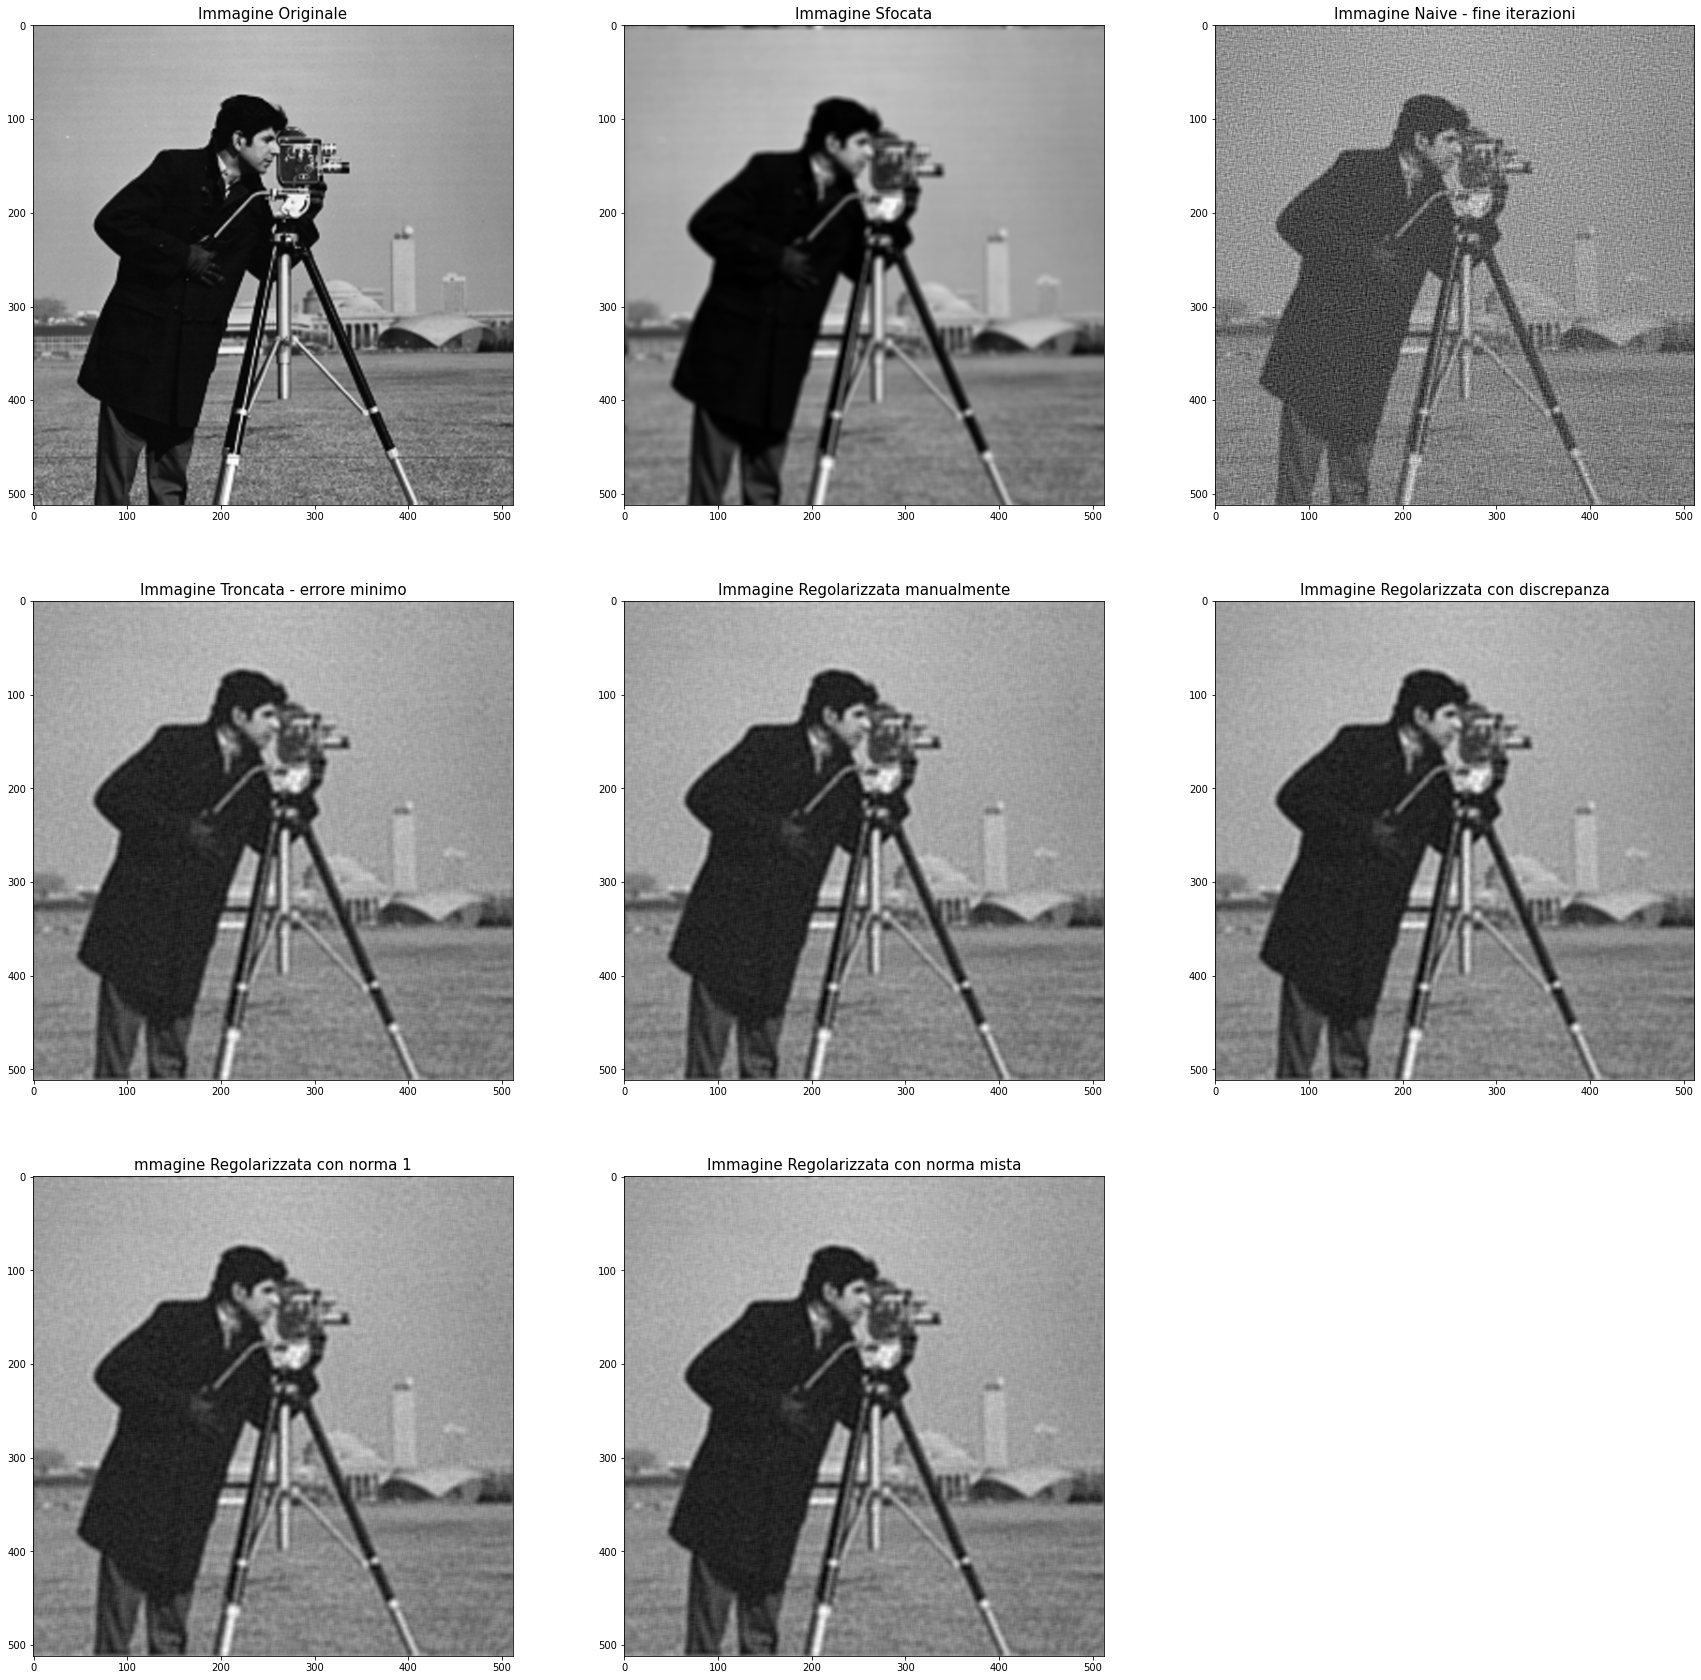

In [23]:

plt.figure(figsize=(30, 30))

im1 = plt.subplot(3, 3, 1)
im1.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=15)

im2 = plt.subplot(3, 3, 2)
im2.imshow(X_blur, cmap='gray')
plt.title('Immagine Sfocata', fontsize=15)

im2 = plt.subplot(3, 3, 3)
im2.imshow(x_naive, cmap='gray')
plt.title('Immagine Naive - fine iterazioni', fontsize=15)

im4 = plt.subplot(3, 3, 4)
im4.imshow(x_tronc, cmap='gray')
plt.title('Immagine Troncata - errore minimo', fontsize=15)

im5 = plt.subplot(3, 3, 5)
im5.imshow(x_reg, cmap='gray')
plt.title('Immagine Regolarizzata manualmente', fontsize=15)

im6 = plt.subplot(3, 3, 6)
im6.imshow(x_reg2, cmap='gray')
plt.title('Immagine Regolarizzata con discrepanza', fontsize=15)

im7 = plt.subplot(3, 3, 7)
im7.imshow(x_norm, cmap='gray')
plt.title('mmagine Regolarizzata con norma 1', fontsize=15)

im8 = plt.subplot(3, 3, 8)
im8.imshow(x_norm_m, cmap='gray')
plt.title('Immagine Regolarizzata con norma mista', fontsize=15)

In [24]:
print('Errori relativi:')
er()
print()
print('PSNR:')
print_PSNR()

Errori relativi:
Errore relativo immagine corrotta:  0.20796533803899706
Errore relativo metodo naive:  0.0903700953505128
Errore relativo metodo euristico:  0.09050258666494558
Errore relativo metodo discrepanza:  0.09451814799620897
Errore relativo metodo norma 1:  0.09036155688276201
Errore relativo metodo misto:  0.09468117837571882

PSNR:
PSNR immagine corrotta: 80.31113535064574
PSNR immagine naive: 80.37303060451072
PSNR immagine regolarizzata euristico: 80.32129699475085
PSNR immagine regolarizzata con discrepanza: 80.08533274491221
PSNR immagine regolarizzata con norma 1: 80.37212280313256
PSNR immagine regolarizzata con norma mista: 80.08209449342026


Ripetere tutti i passaggi, variando il livello del rumore (controllato dalla variabile $\sigma$), i parametri del kernel di sfocamento Gaussiano, e l'immagine di test. \\
Per la scelta delle immagini di test, utilizzare immagini **in bianco e nero, a scelta**, prese da internet, che rispettino i seguenti criteri:


*   Almeno un'immagine "geometrica", ovvero con pochi dettagli e contorni netti e ben contrastati (es. QRCode, Codice a Barre, Scacchiera...).
*   Almeno un'immagine "fotografica", ovvero con molti dettagli e livelli di grigio sfocati.
*   Almeno un'immagine contenente del testo, che diventerà difficilmente leggibile dopo il processo di sfocamento.


Osservare quale metodo di ricostruzione si comporta meglio nei vari esperimenti, ricordandosi corrompere l'immagine di input sia con rumore Gaussiano che con sfocatura.

